<a href="https://colab.research.google.com/github/crowell97/ES2245/blob/main/es2245_lecture10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARTHSC 2245: Lecture 10 - Normality Tests & Non-Normal Distributions in Earth Sciences
**Topic:** Visualizing data, testing for normality, and understanding specific geological probability distributions.

---

## 1. Setup and Libraries
We will use `numpy` for data generation, `matplotlib` and `seaborn` for plotting, and `scipy.stats` for statistical tests.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. The Chi-Squared Goodness of Fit Test
The Chi-Squared ($\chi^2$) test checks if a sample matches a theoretical distribution (usually the Normal Distribution).

**The Formula:**
$$\chi^2 = \sum \frac{(O - E)^2}{E}$$
Where $O$ is Observed frequency and $E$ is Expected frequency.

**Null Hypothesis ($H_0$):** The data follows a normal distribution.  
**Significance:** If $P < 0.05$, we reject $H_0$ (the data is NOT normal).

### Example: Testing a Random Sample
We will generate a normal dataset and a non-normal (uniform) dataset to see how the test performs.

Normal Data: Chi2=5.53, P-value=0.7858 (Interpret: Normal)
Uniform Data: Chi2=208.91, P-value=0.0000 (Interpret: Not Normal)


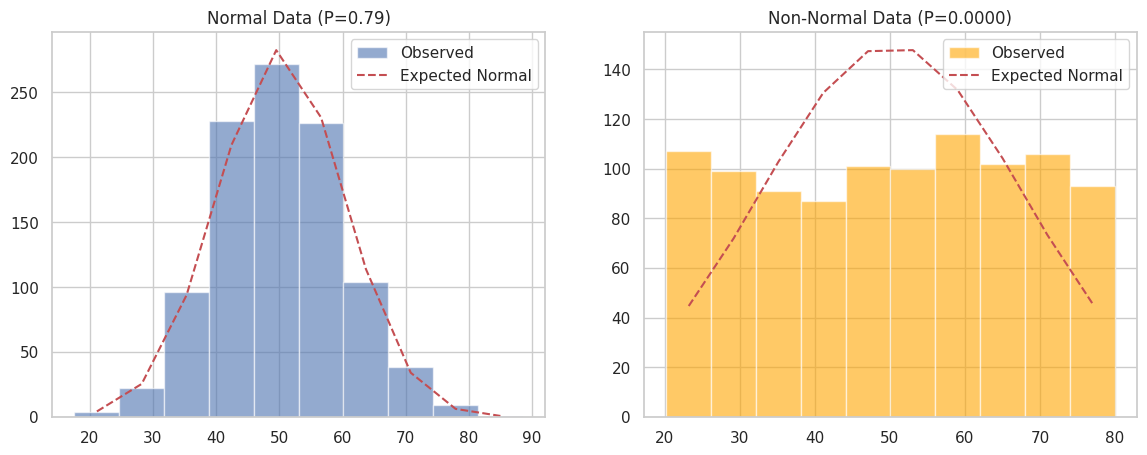

In [2]:
def chi_squared_normality_test(data, bins=10):
    """
    Performs a Chi-Squared Goodness of Fit test for Normality.
    """
    # 1. Histogram of observed data
    observed_freq, bin_edges = np.histogram(data, bins=bins)

    # 2. Calculate Expected Frequencies for a Normal Distribution
    mu, sigma = np.mean(data), np.std(data)
    expected_freq = []

    for i in range(len(bin_edges)-1):
        # Probability of falling in this bin under a normal curve
        upper_cdf = stats.norm.cdf(bin_edges[i+1], mu, sigma)
        lower_cdf = stats.norm.cdf(bin_edges[i], mu, sigma)
        prob = upper_cdf - lower_cdf
        expected_freq.append(prob * len(data))

    expected_freq = np.array(expected_freq)

    # Adjust for small expected frequencies (simple normalization for this demo)
    # Note: In rigorous analysis, bins with E < 5 should be merged.
    expected_freq = expected_freq * (np.sum(observed_freq) / np.sum(expected_freq))

    # 3. Chi-Squared Test
    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

    return chi2_stat, p_value, bin_edges, observed_freq, expected_freq

# Generate Data
np.random.seed(42)
normal_data = np.random.normal(loc=50, scale=10, size=1000)
non_normal_data = np.random.uniform(low=20, high=80, size=1000) # Flat distribution

# Run Tests
chi2_n, p_n, bins_n, obs_n, exp_n = chi_squared_normality_test(normal_data)
chi2_nn, p_nn, bins_nn, obs_nn, exp_nn = chi_squared_normality_test(non_normal_data)

print(f"Normal Data: Chi2={chi2_n:.2f}, P-value={p_n:.4f} (Interpret: {'Normal' if p_n > 0.05 else 'Not Normal'})")
print(f"Uniform Data: Chi2={chi2_nn:.2f}, P-value={p_nn:.4f} (Interpret: {'Normal' if p_nn > 0.05 else 'Not Normal'})")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Normal Data
ax[0].hist(normal_data, bins=bins_n, alpha=0.6, label='Observed')
ax[0].plot((bins_n[:-1]+bins_n[1:])/2, exp_n, 'r--', label='Expected Normal')
ax[0].set_title(f'Normal Data (P={p_n:.2f})')
ax[0].legend()

# Plot Non-Normal Data
ax[1].hist(non_normal_data, bins=bins_nn, color='orange', alpha=0.6, label='Observed')
ax[1].plot((bins_nn[:-1]+bins_nn[1:])/2, exp_nn, 'r--', label='Expected Normal')
ax[1].set_title(f'Non-Normal Data (P={p_nn:.4f})')
ax[1].legend()

plt.show()

## 3. Box Plots vs. Violin Plots
**Box Plots** are excellent for summarizing data (Median, IQR, Outliers) and checking for skew.
**Violin Plots** combine a box plot with a Kernel Density Estimation (KDE).

**Why use Violin Plots?**
They reveal the *shape* of the distribution. A box plot can hide bimodal data (two peaks), whereas a violin plot clearly shows it.

### Example: Bimodal Distribution (e.g., Two distinct grain size populations)

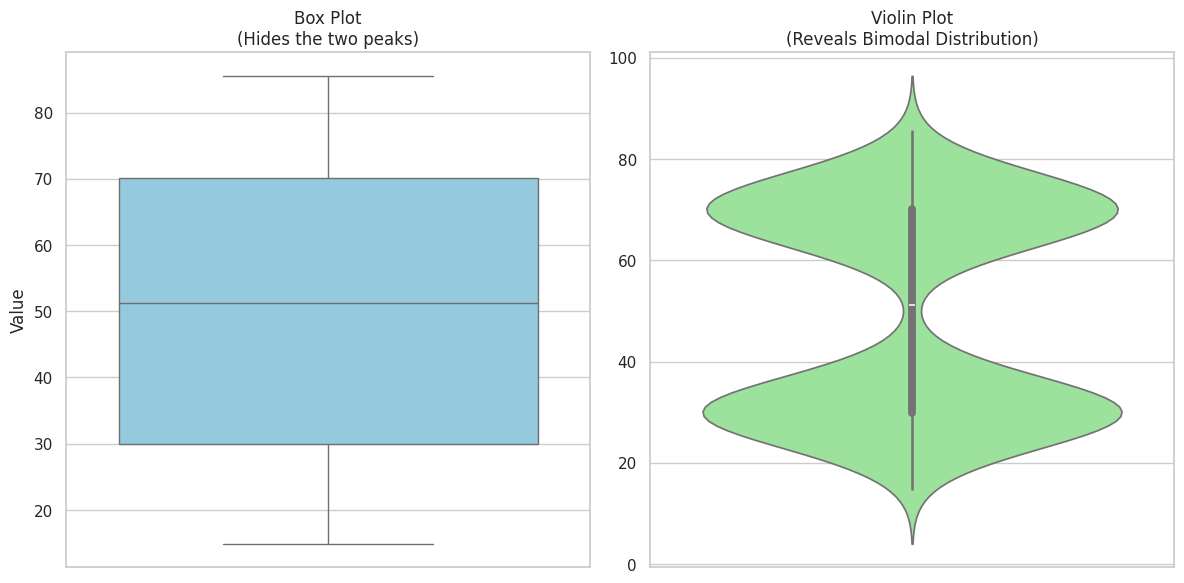

In [3]:
# Generate Bimodal Data (e.g., a mix of sand and gravel)
population_1 = np.random.normal(30, 5, 400)
population_2 = np.random.normal(70, 5, 400)
bimodal_data = np.concatenate([population_1, population_2])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box Plot
sns.boxplot(y=bimodal_data, ax=axes[0], color='skyblue')
axes[0].set_title("Box Plot\n(Hides the two peaks)")
axes[0].set_ylabel("Value")

# Violin Plot
sns.violinplot(y=bimodal_data, ax=axes[1], color='lightgreen')
axes[1].set_title("Violin Plot\n(Reveals Bimodal Distribution)")

plt.tight_layout()
plt.show()

## 4. Directional Data: The Rose Diagram
In structural geology (faults) or glaciology (striations), data is directional (0-360°).
Standard histograms don't work well because 0° and 360° are the same. We use **Rose Diagrams**.

**Important Note:** To avoid visual bias, the **area** of the wedges (petals) should be proportional to frequency, not just the length.

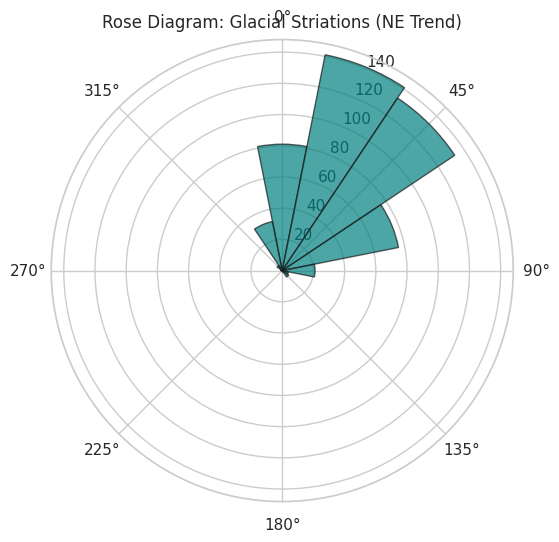

In [4]:
# Generate Directional Data (Von Mises Distribution - "Circular Normal")
# Simulating glacial striations clustered around North-East (45 degrees)
direction_data_rad = np.random.vonmises(mu=np.radians(45), kappa=4, size=500)
direction_data_deg = np.degrees(direction_data_rad) % 360

def plot_rose_diagram(data_degrees, bins=16):
    """
    Plots a Rose Diagram (Polar Histogram).
    """
    bin_edges = np.linspace(0.0, 2 * np.pi, bins + 1)
    counts, _ = np.histogram(np.radians(data_degrees), bins=bin_edges)

    # Compute width of each bin
    width = 2 * np.pi / bins

    # Set up polar plot
    ax = plt.subplot(111, projection='polar')

    # Plot bars
    # Note: We use the 'bottom' parameter to start from center
    bars = ax.bar(bin_edges[:-1], counts, width=width, bottom=0.0,
                  color='teal', edgecolor='k', alpha=0.7)

    # Standard compass settings
    ax.set_theta_zero_location('N')  # 0 degrees at top (North)
    ax.set_theta_direction(-1)       # Clockwise
    ax.set_title("Rose Diagram: Glacial Striations (NE Trend)", va='bottom')

    plt.show()

plot_rose_diagram(direction_data_deg)

## 5. Lognormal Distributions in Earth Science
Many geological variables (Trace elements, Permeability, Grain Size) follow a **Lognormal Distribution**.
* **Cause:** Multiplicative processes or physical constraints (values cannot be $< 0$).
* **Characteristics:** High positive skew (long tail to the right). Mean > Median.
* **Handling:** Apply a Log-Transformation ($Y = \log(X)$) to normalize.

### Example: Gold Concentration (ppm)
Gold often has a low background concentration with rare high-grade "nuggets" or deposits.

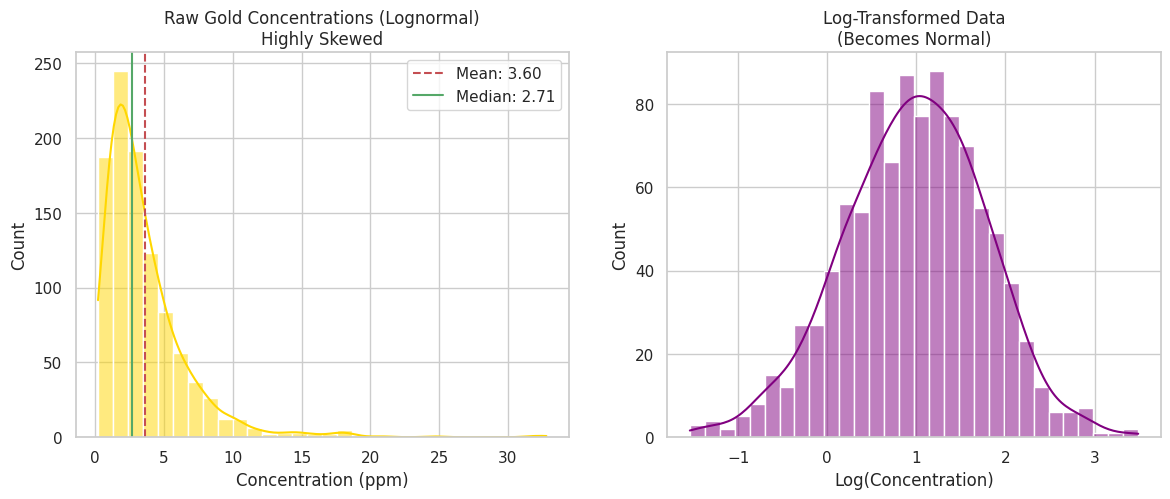

In [5]:
# Generate Lognormal Data (e.g., Gold assays in ppm)
# Underlying normal distribution parameters (mean=1, sigma=0.8 in log space)
gold_data = np.random.lognormal(mean=1, sigma=0.8, size=1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Raw Data (Linear Scale)
sns.histplot(gold_data, bins=30, kde=True, ax=axes[0], color='gold')
axes[0].set_title("Raw Gold Concentrations (Lognormal)\nHighly Skewed")
axes[0].set_xlabel("Concentration (ppm)")
axes[0].axvline(np.mean(gold_data), color='r', linestyle='--', label=f'Mean: {np.mean(gold_data):.2f}')
axes[0].axvline(np.median(gold_data), color='g', linestyle='-', label=f'Median: {np.median(gold_data):.2f}')
axes[0].legend()

# 2. Log-Transformed Data
log_gold = np.log(gold_data)
sns.histplot(log_gold, bins=30, kde=True, ax=axes[1], color='purple')
axes[1].set_title("Log-Transformed Data\n(Becomes Normal)")
axes[1].set_xlabel("Log(Concentration)")

plt.show()

## 6. The Poisson Distribution
Describes "Rare Events" occurring in a continuum (time or space) where the average rate ($\lambda$) is known.

**Key Property:** Variance $\approx$ Mean ($\sigma^2 \approx \lambda$).
* If Variance > Mean: Clustered (Over-dispersed).
* If Variance < Mean: Uniform (Under-dispersed).

### Example: Volcanic Eruptions
**Scenario:** A volcano has an average rate of $\lambda = 0.05$ eruptions/year (1 every 20 years).
**Question:** What is the probability of exactly 0 eruptions in the next 10 years? Or 2 or more?

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-930511391.py:25: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Poisson Probability of Eruptions in Next {years} Years ($\lambda={lambda_total}$)')


Expected Eruptions in 10 years (Lambda): 0.5
----------------------------------------
 Number of Eruptions (k)  Probability  Percentage
                       0     0.606531   60.653066
                       1     0.303265   30.326533
                       2     0.075816    7.581633
                       3     0.012636    1.263606
                       4     0.001580    0.157951
                       5     0.000158    0.015795


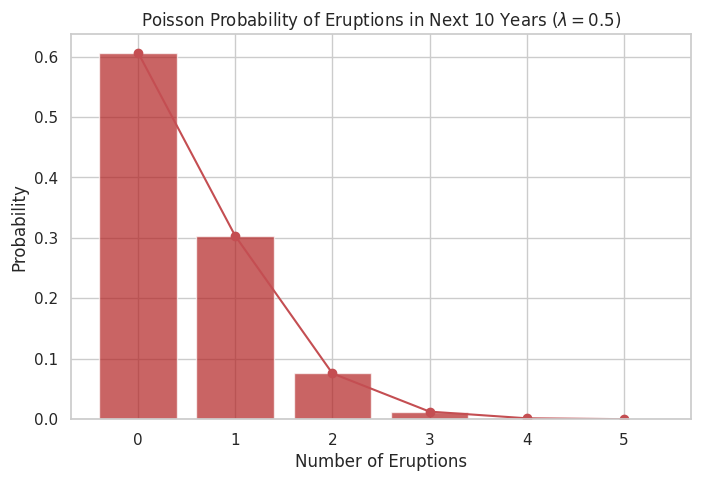

Probability of 2 or more eruptions: 0.0902 (9.02%)


In [6]:
# Parameters
lambda_per_year = 0.05
years = 10
lambda_total = lambda_per_year * years  # Expected eruptions in 10 years = 0.5

# Calculate Probabilities using Poisson Mass Function (PMF)
k_values = np.arange(0, 6) # checking probabilities for 0 to 5 eruptions
probs = stats.poisson.pmf(k_values, lambda_total)

# Create DataFrame for display
df_poisson = pd.DataFrame({
    'Number of Eruptions (k)': k_values,
    'Probability': probs,
    'Percentage': probs * 100
})

print(f"Expected Eruptions in {years} years (Lambda): {lambda_total}")
print("-" * 40)
print(df_poisson.to_string(index=False))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(k_values, probs, color='firebrick', alpha=0.7)
plt.plot(k_values, probs, 'ro-')
plt.title(f'Poisson Probability of Eruptions in Next {years} Years ($\lambda={lambda_total}$)')
plt.xlabel('Number of Eruptions')
plt.ylabel('Probability')
plt.xticks(k_values)
plt.show()

# Probability of "2 or more" (1 - probability of 0 or 1)
prob_2_or_more = 1 - stats.poisson.cdf(1, lambda_total)
print(f"Probability of 2 or more eruptions: {prob_2_or_more:.4f} ({prob_2_or_more*100:.2f}%)")